In [1]:
import numpy as np

from sparse_sim.fermion.fermion import *
from sparse_sim.fermion.hamiltonian import *
from sparse_sim.fermion.projector import *
from sparse_sim.fermion.qiskit_wrapper import *
from sparse_sim.cython.core import *

from CETE.CETE_helper_H2 import *

In [2]:
tau = 0.03  # Size of substep in Ha^-1
tau_iters = 30 # Number of substeps per step
time_steps = 20 # Number of steps

max_iters = 10 # Max numbers of iteration to optimize the ansatz per time step
convergence = 1e-10 # Convergence for optimization of ansatz per time step
parameters = np.load('../analytical_parameters/parameters.npy', allow_pickle=True) # Parameters for analytical derivatives

# Initial state psi_0
sdet0 = SlaterDeterminant(1, 1, [0])
psi0 = 1 * sdet0
psi_circuit = q.QuantumCircuit(psi0.N, 0)
pStringX = PauliString(1, 1, ["X"])
psi_circuit.compose(qiskit_create_pauli_string_evolution_circuit(pStringX, 1j * np.pi/10), inplace=True)
print(f"psi0: {format_statevector(create_statevector(psi0, psi_circuit), psi0.N)}") # Prints in big-endian format

# Hamiltonian is retrieved from PySCF
dist0 = 0.7348654  
# Equilibrium distance for ground state H2 using sto-3g basis in Angstroms
H2 = gto.M(
    atom=f"H 0 0 0; H 0 0 {dist0}",
    basis="sto-3g",
    charge=0,
    spin=0,
    unit="Angstrom"
).build()

H2_4q = init_Hamiltonian_from_pyscf(H2) 

gates = ['id', 'sx', 'x', 'cz', 'rz'] # Gates used by backend
backend = Aer.AerSimulator(method='statevector', basis_gates=gates) # Note: this is a noiseless simulator
pm = generate_preset_pass_manager(backend=backend) # Pass manager for Qiskit transpiler
mit = None # M3Mitigation 
shots = 10**4 
shots_residual = 2 * 10**4
# Optimization level for Qiskit transpiler
optimization_level = 0

# The CETE algorithms run and results are saved here
label = f"{tau}_{tau_iters}_{time_steps}"
output_dir = f"results/H2_{label}"
os.makedirs(output_dir, exist_ok=True)

CETE_ordms, CETE_energies, CETE_depths, CETE_fids, times, sequential_ordms, sequential_energies, sequential_depths = run_H2_1q(
    psi0, psi_circuit, H2_4q, tau, tau_iters, time_steps, max_iters, convergence, parameters, optimization_level, shots, shots_residual, backend, pm, mit)

elecs_output_file = f"{output_dir}/elecs_summary.npy"
np.save(elecs_output_file, np.array(CETE_ordms, dtype=object))
energies_output_file = f"{output_dir}/energies_summary.npy"
np.save(energies_output_file, np.array(CETE_energies))
depths_output_file = f"{output_dir}/depths_summary.npy"
np.save(depths_output_file, np.array(CETE_depths))
fids_output_file = f"{output_dir}/fids_summary.npy"
np.save(fids_output_file, np.array(CETE_fids))
times_output_file = f"{output_dir}/times_summary.npy"
np.save(times_output_file, np.array(times))
trad_elecs_output_file = f"{output_dir}/trad_elecs_summary.npy"
np.save(trad_elecs_output_file, np.array(sequential_ordms, dtype=object))
trad_energies_output_file = f"{output_dir}/trad_energies_summary.npy"
np.save(trad_energies_output_file, np.array(sequential_energies))
trad_depths_output_file = f"{output_dir}/trad_depths_summary.npy"
np.save(trad_depths_output_file, np.array(sequential_depths))

psi0: 0.9511+0.0000j * |0> + 0.0000+0.3090j * |1>


In [3]:
# Reference state
sdet1010 = SlaterDeterminant(4, 1, [1, 0, 1, 0]) # big-endian format
psi0_4q = 1 * sdet1010
psi_circuit_4q = q.QuantumCircuit(psi0_4q.N, 0)
double_excitation = Product(1, [FermionicOperator("+", 1, 4), FermionicOperator("+", 3, 4), FermionicOperator("-", 2, 4), FermionicOperator("-", 0, 4)], 4)
A = Operator([double_excitation, double_excitation.adjoint()], 4) 
psi_circuit_4q.compose(qiskit_create_pauli_sum_evolution_circuit(A.pSum, 1j * np.pi/10), inplace=True)
print(f"psi0 4q reference: {format_statevector(create_statevector(psi0_4q, psi_circuit_4q), psi0_4q.N)}") # Prints in big-endian format

reference_ordms, reference_energies, reference_times = generate_reference(psi0_4q, psi_circuit_4q, H2_4q, tau, tau_iters, time_steps)

psi0 4q reference: 0.9511-0.0000j * |1010> + 0.0000+0.3090j * |0101>
On time step 1 of 20
On time step 2 of 20
On time step 3 of 20
On time step 4 of 20
On time step 5 of 20
On time step 6 of 20
On time step 7 of 20
On time step 8 of 20
On time step 9 of 20
On time step 10 of 20
On time step 11 of 20
On time step 12 of 20
On time step 13 of 20
On time step 14 of 20
On time step 15 of 20
On time step 16 of 20
On time step 17 of 20
On time step 18 of 20
On time step 19 of 20
On time step 20 of 20


**Note:** This data was generated by evaluating circuits on the noiseless AerSimulator. Thus, circuit depth does not impact the accuracy of results.

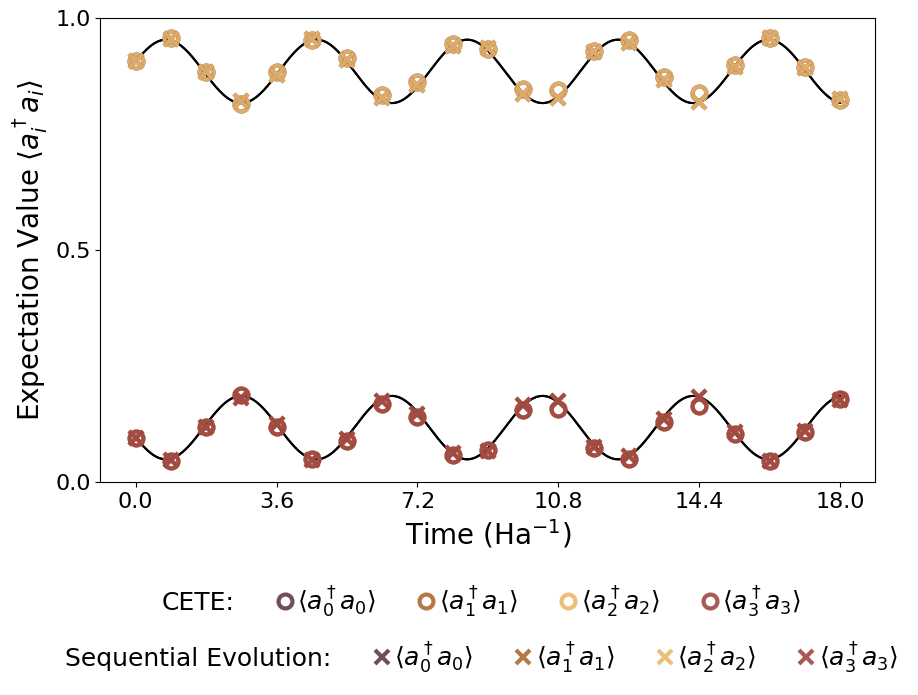

In [4]:
plot_ordms(CETE_ordms, sequential_ordms, times, reference_ordms, reference_times)

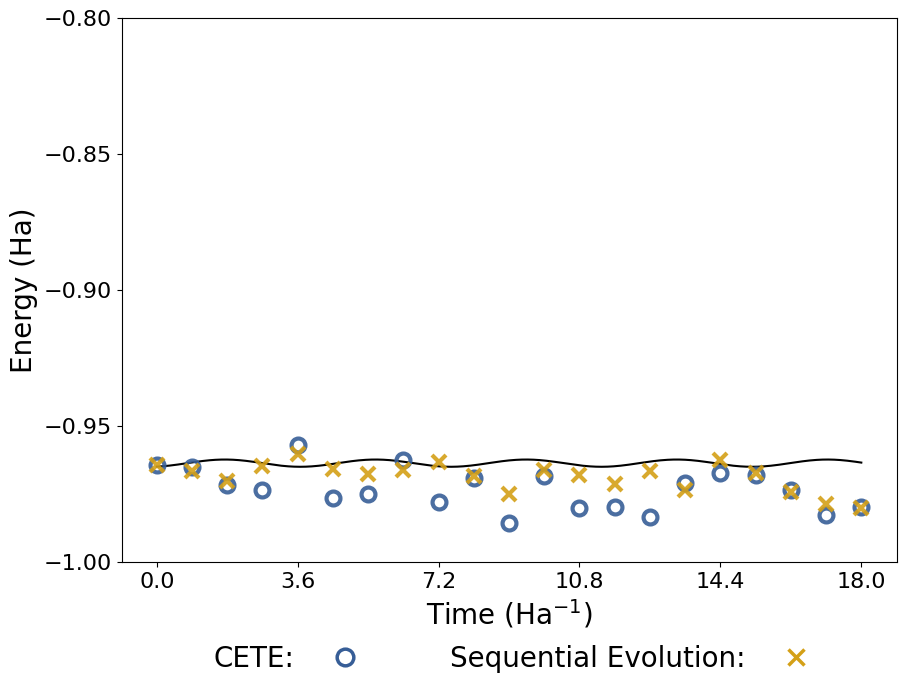

In [5]:
plot_energies(CETE_energies, sequential_energies, times, reference_energies, reference_times)

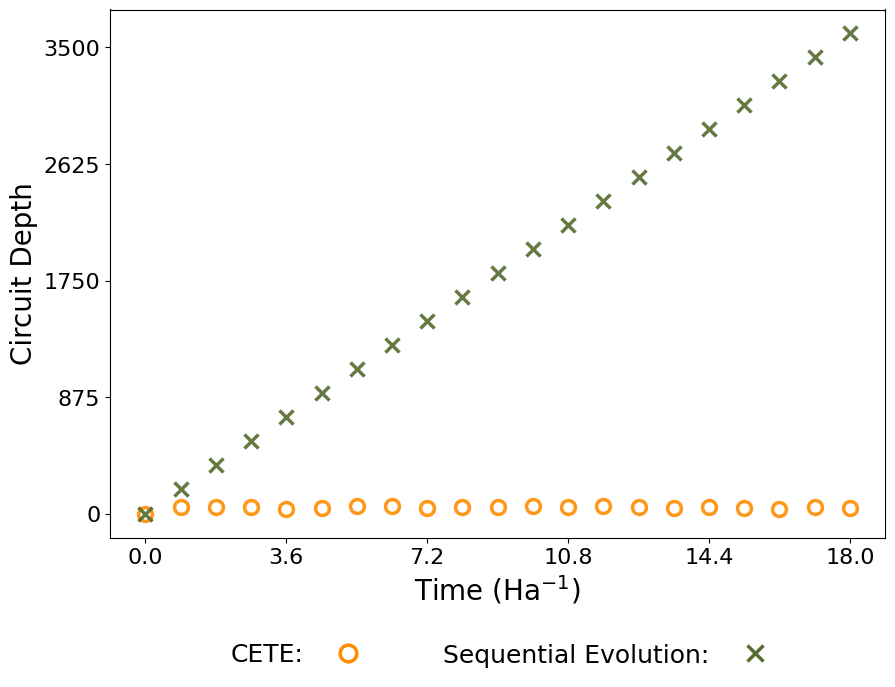

In [6]:
plot_circuit_depths(CETE_depths, sequential_depths, times)